In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import KNNImputer, SimpleImputer

import lightgbm as lgm

from tabpfn import TabPFNClassifier

from lofo import LOFOImportance, Dataset, plot_importance

import optuna

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

In [73]:
def competition_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # Implements the Evaluation equation with w_0 = w_1 = 1.
    # Calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1)/2

In [4]:
train_df = pd.read_csv('train.csv')
greek_df = pd.read_csv('greeks.csv')
test_df = pd.read_csv('test.csv')

train_df.columns = [col.strip() for col in train_df.columns]
train_df['EJ'] = train_df['EJ'].map({'B' : 0, 'A':1})

test_df.columns = [col.strip() for col in test_df.columns]
test_df['EJ'] = test_df['EJ'].map({'B': 0, 'A' : 1})

In [5]:
int_denominators = {
 'AB': 0.004273,
 'AF': 0.00242,
 'AH': 0.008709,
 'AM': 0.003097,
 'AR': 0.005244,
 'AX': 0.008859,
 'AY': 0.000609,
 'AZ': 0.006302,
 'BC': 0.007028,
 'BD': 0.00799,
 'BN': 0.3531,
 'BP': 0.004239,
 'BQ': 0.002605,
 'BR': 0.006049,
 'BZ': 0.004267,
 'CB': 0.009191,
 'CC': 6.12e-06,
 'CD': 0.007928,
 'CF': 0.003041,
 'CH': 0.000398,
 'CL': 0.006365,
 'CR': 7.5e-05,
 'CS': 0.003487,
 'CU': 0.005517,
 'CW': 9.2e-05,
 'DA': 0.00388,
 'DE': 0.004435,
 'DF': 0.000351,
 'DH': 0.002733,
 'DI': 0.003765,
 'DL': 0.00212,
 'DN': 0.003412,
 'DU': 0.0013794,
 'DV': 0.00259,
 'DY': 0.004492,
 'EB': 0.007068,
 'EE': 0.004031,
 'EG': 0.006025,
 'EH': 0.006084,
 'EL': 0.000429,
 'EP': 0.009269,
 'EU': 0.005064,
 'FC': 0.005712,
 'FD': 0.005937,
 'FE': 0.007486,
 'FI': 0.005513,
 'FR': 0.00058,
 'FS': 0.006773,
 'GB': 0.009302,
 'GE': 0.004417,
 'GF': 0.004374,
 'GH': 0.003721,
 'GI': 0.002572
}
for k, v in int_denominators.items():
    train_df[k] = np.round(train_df[k]/v,1)

In [6]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,7.298162,2997.5,14.0,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,0.173229,857.0,84.0,999.0,16439.0,6397248.0,7830.0,12493.0,21.978000,0
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,7.709560,1682.0,177.0,3986.0,20061.0,3126876.5,7531.0,13683.0,0.196941,0
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,6.122162,857.0,42.0,1992.0,18659.0,478798.0,10736.0,35184.0,0.155829,0
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,8.153058,83623.0,18.0,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1


In [7]:
greek_df.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [111]:
idx = greek_df[greek_df['Epsilon'] == 'Unknown'].index

no_unknown = train_df[~train_df.index.isin(idx)]

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,7.298162,2997.5,14.0,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,8.153058,83623.0,18.0,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1
5,04517a3c90bd,49.0,1080915.0,9783.0,2758.0,1552.0,453.0,42.0,1991.0,175.0,...,0.173229,857.0,172.0,2356.0,16439.0,5527571.0,7666.0,32087.0,21.978000,0
6,049232ca8356,81.5,716386.0,9783.0,2705.0,2920.0,216.0,42.0,1039.0,175.0,...,4.408484,1485.0,69.0,1922.0,43571.0,761881.0,9182.0,38914.0,0.065096,0
7,057287f2da6d,63.0,399361.5,9783.0,6837.0,1552.0,563.0,42.0,1493.0,175.0,...,6.591896,857.0,41.0,1983.0,24834.5,4886090.5,9462.0,12218.0,0.092873,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,fd1dd68d51b4,41.0,1077383.0,9783.0,2282.0,1552.0,455.0,42.0,539.0,175.0,...,0.173229,3267.0,206.0,1818.0,55715.0,2505799.0,10314.5,15944.0,21.978000,0
612,fd3dafe738fd,35.0,1293413.0,14211.0,3072.0,2483.0,395.0,127.0,1356.0,399.0,...,0.173229,2174.0,10.0,964.0,49162.0,1850922.0,6622.0,26902.0,21.978000,0
613,fd895603f071,102.0,2257039.0,9783.0,15031.0,3046.0,675.0,42.5,2003.0,537.5,...,10.223150,2142.0,63.0,3859.0,112518.5,705374.5,7968.0,48526.0,0.145340,0
614,fd8ef6377f76,100.0,1016160.0,14943.0,17874.0,1908.0,911.0,42.0,2445.0,175.0,...,0.173229,857.0,10.0,2146.0,29182.0,1480259.0,7032.0,46485.0,21.978000,0


In [8]:
class WeightedEns(BaseEstimator):
    def __init__(self):
        self.param_grid = {'learning_rate': 0.07103098041575105,
                           'num_iterations': 504,
                           'num_leaves': 50,
                           'max_depth': 3,
                           'min_data_leaf': 52}
        self.classifiers = [lgm.LGBMClassifier(**self.param_grid, class_weight='balanced'),TabPFNClassifier(N_ensemble_configurations=64)]
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median')
    
    def fit(self, X, y):
        cls, y = np.unique(y, return_inverse=True)
        self.classes_ = cls
        X = self.imp.fit_transform(X)
        for cl in self.classifiers:
            cl.fit(X,y)
    
    def predict_proba(self, X):
        X = self.imp.transform(X)
        ps = np.stack([cl.predict_proba(X) for cl in self.classifiers])
        p = np.mean(ps,axis=0)
        class_0_est_instances = p[:,0].sum()
        others_est_instances = p[:,1:].sum()
        
        # reweighting the predictions for balanced log loss
        new_p = p * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(p.shape[1])]])
        return new_p / np.sum(new_p,axis=1,keepdims=1)

In [ ]:
scores = []
balance_score = []
oofs = []

for n in range(50):

    skf = StratifiedKFold(n_splits=10, shuffle=True)

    X = train_df.drop(columns=['AF', 'FL', 'EJ', 'FE']).copy()
    y = train_df['Class'].values

    models = {}
    oof = np.zeros(len(X))

    for i, (train, val) in enumerate(skf.split(X, y)):

        train_x = X.iloc[train].drop(columns=['Id', 'Class']).copy()
        train_y = y[train]

        POS_CLASS = train_y.sum()    
        undersampler = RandomUnderSampler(sampling_strategy={0: POS_CLASS, 1: POS_CLASS})
        resampled_x, resampled_y = undersampler.fit_resample(train_x, train_y)

        # getting the id values
        id_val = X.iloc[val]['Id']
        val_x = X.iloc[val].drop(columns=['Id', 'Class']).copy()
        val_y = y[val]

        model = lgm.LGBMClassifier(boosting_type='goss',
                                   learning_rate=0.06733232950390658,
                                   n_estimators = 50000, 
                                   early_stopping_round = 300,
                                   random_state=42,
                                   subsample=0.6970532011679706,
                                   colsample_bytree=0.6055755840633003,
                                   max_depth=8,
                                   class_weight='balanced',
                                   metric='none', 
                                   is_unbalance=True)

        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], eval_metric=lgb_metric, verbose=False)

        preds = model.predict_proba(val_x)[:,1]

    #     oof.loc[id_val, 'pred'] = preds
        oof[val] = preds

        models[f'model_{i}'] = model

    # id_class_dict = train_df.set_index('Id')['Class'].to_dict()
    # oof['class'] = oof.index.map(id_class_dict)
    scores.append(balanced_log_loss(y, oof))
    balance_score.append(competition_log_loss(y, oof))
    oofs.append(oof)

In [142]:
oof_df = pd.DataFrame()

for preds in oofs:
    oof_series = pd.Series(preds)
    oof_df = pd.concat([oof_df, oof_series], axis=1)
    
patient_preds = pd.DataFrame({'mean_prediction' : oof_df.mean(axis=1),
                              'std_prediction' : oof_df.std(axis=1),
                              'min_prediction' : oof_df.min(axis=1).round(4),
                              'max_prediction' : oof_df.max(axis=1)})

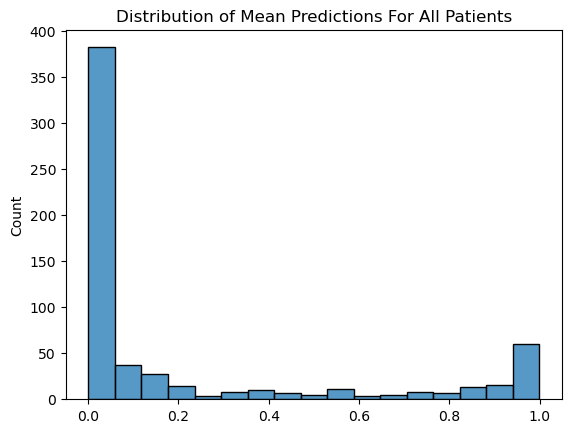

In [165]:
sns.histplot(oof_df.mean(axis=1))
plt.title("Distribution of Mean Predictions For All Patients")
plt.show()

In [163]:
def plot_patient_preds(idx=0):
    sns.histplot(oof_df.iloc[idx])
    
    plt.title(f"Predictions for patient {idx}")
    plt.show()

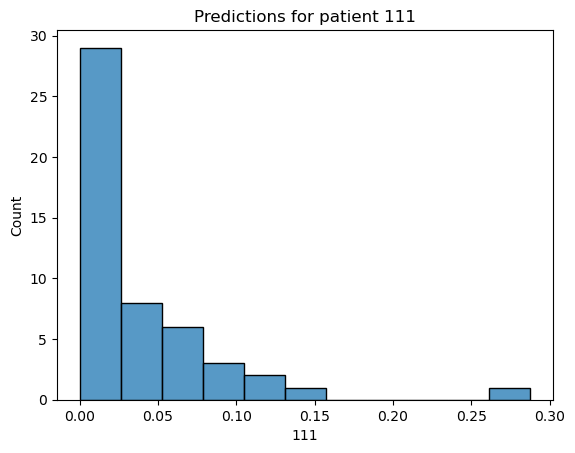

In [164]:
plot_patient_preds(111)

In [ ]:
model = lgm.LGBMClassifier(boosting_type='goss',
                       learning_rate=0.06733232950390658,
                       n_estimators = 50000, 
                       early_stopping_round = 300,
                       random_state=42,
                       subsample=0.6970532011679706,
                       colsample_bytree=0.6055755840633003,
                       max_depth=8,
                       class_weight='balanced',
                       metric='none', 
                       is_unbalance=True)

model.fit(train_x, train_y, eval_set=[(val_x, val_y)], eval_metric=lgb_metric, early_stopping_rounds=35)

In [23]:
fi_df = train_df.drop(columns=['Id']).copy()

cv = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
data = Dataset(df=fi_df, target="Class", features=[col for col in fi_df.columns if col not in ['Class', 'AF', 'FL', 'EJ', 'FE']])

model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 888,
                           random_state=42,
                           subsample=0.6970532011679706,
                           colsample_bytree=0.6055755840633003,
                           max_depth=8,
                           class_weight='balanced')

lofo_imp = LOFOImportance(data, cv=cv, scoring='neg_log_loss', model=model)
importance_df = lofo_imp.get_importance()

  0%|          | 0/52 [00:00<?, ?it/s]

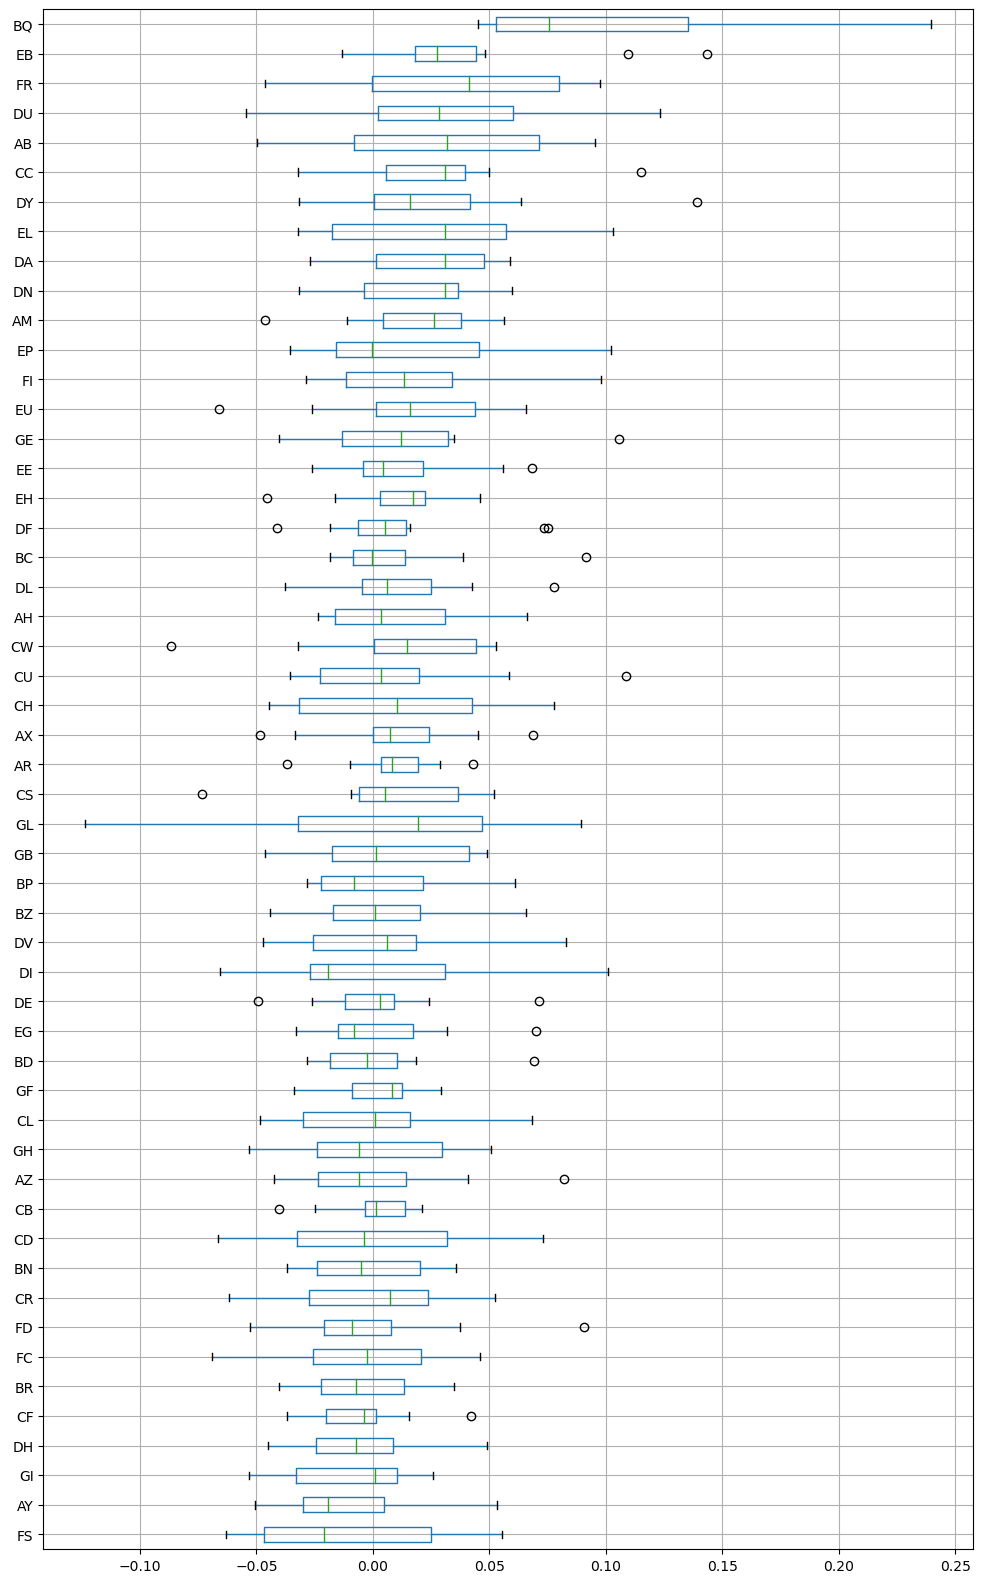

In [25]:
plot_importance(importance_df, figsize=(12, 20), kind='box')

In [97]:
test_preds = pd.DataFrame()

for model in models.keys():
    features = models[model].feature_name_
    p = models[model].predict_proba(test_df[features])[:,1]
    test_preds = pd.concat([test_preds, pd.Series(p)], axis=1)

test_preds.mean(axis=1)

0    0.453747
1    0.453747
2    0.453747
3    0.453747
4    0.453747
dtype: float64